*italicized text*

Run the model only on collab 

Hierarchial attention network uses GPU to train and hence we have trained the model on Collab.


before running the code make sure that you hve turned the GPU ON. To do so go to RUNTIME and then CHANGE RUNTIME TYPES. In that switch the Hardware accelerator to use GPU.

In order to confirm that GPU is turned on the below code should return  '/device:GPU:0'

In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
#installing requirements for downloading files from drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 993kB 6.7MB/s 


In [0]:
#google drive link for the cleaned, labelled pre processed youtube data
link='https://drive.google.com/open?id=1SAZ5_KrNHQe8FSsdrBQQGTF61yKUmXuW'

In [0]:
fluff, id = link.split('=')
print (id) 

1SAZ5_KrNHQe8FSsdrBQQGTF61yKUmXuW


In [0]:
import pandas as pd

In [0]:
Sometime the below lines get buggy. I case you get an error , please run the cell again!

In [0]:
#downloading the data from the link
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('labelled_processed_youtube_data.csv')
 


In [0]:
df = pd.read_csv('labelled_processed_youtube_data.csv').drop(["Unnamed: 0"],axis=1)

In [0]:
df.shape

(8210, 10)

In [0]:
#creating a feature
df['ratio']=df['dislikes']/df['likes']

In [0]:
df.shape

(8210, 11)

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

import os

import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, CuDNNLSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.optimizers import Adam
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, optimizers, layers


Using TensorFlow backend.


In [0]:
def split_text(x):
    x = wordninja.split(x)
    return '-'.join(x)

In [0]:
  df["merged"] = df["merged"].str.lower()
  print("Train shape : ",df.merged.shape)

Train shape :  (8210,)


In [0]:
 df=df.reindex(np.random.permutation(df.index))

In [0]:
df['ratio']=df['ratio'].fillna(0)

In [0]:
#train test split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2018)
#train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=2018)
print(train_df.shape)
print(test_df.shape)


(6568, 11)
(1642, 11)


In [0]:
 ## fill up the missing values
train_X = train_df["merged"].fillna("_##_").values
#val_X = val_df["merged"].fillna("_##_").values
test_X = test_df["merged"].fillna("_##_").values


In [0]:
  #defining the embeddings and other parameters
  embed_size = 300 # how big is each word vector
  max_features = 36156 # how many unique words to use (i.e num rows in embedding vector)
  maxlen = 500

In [0]:
#tokenising the text data
tokenizer = Tokenizer(num_words=max_features)
a=tokenizer.fit_on_texts(list(df['merged']))
train_X = tokenizer.texts_to_sequences(train_X)
#val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

In [0]:
## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen)
#val_X = pad_sequences(val_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)

In [0]:
## Get the target values
train_y = train_df['label'].values
test_y = test_df['label'].values 

In [0]:
# wiki_news embeddings
embedding_link1= 'https://drive.google.com/open?id=1i1EVafb-d4SrdQYT_PpLIYq2A2X25Ac_'
# paragram embeddings
embedding_link2= 'https://drive.google.com/open?id=1nV0gO-d6GIrlr_0RRD1k1ZlekOfv9wSi'
# glove embeddings
embedding_link3= 'https://drive.google.com/open?id=1aRfxfzT1UXuo_qbg_J3_GG8HsbL7L4gr'

In [0]:
fluff, id = embedding_link1.split('=')
print (id)


1i1EVafb-d4SrdQYT_PpLIYq2A2X25Ac_


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('wiki-news-300d-1M.vec')  


In [0]:
fluff, id = embedding_link2.split('=')
print (id)

1nV0gO-d6GIrlr_0RRD1k1ZlekOfv9wSi


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('paragram_300_sl999.txt')

In [0]:
fluff, id = embedding_link3.split('=')
print (id)

1aRfxfzT1UXuo_qbg_J3_GG8HsbL7L4gr


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('glove.840B.300d') 

In [0]:
#The size of the embeddings are very large.  It is adviced to use only one ebedding in one instance for making sure that the code runs properly.


In [0]:
#creating respective embeddings


def load_fasttext(word_index):    
    EMBEDDING_FILE = 'wiki-news-300d-1M.vec'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE,encoding="utf8") if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector

    return embedding_matrix
  
def load_glove(word_index):
    EMBEDDING_FILE = 'glove.840B.300d'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values()+1)
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 


def load_para(word_index):
    EMBEDDING_FILE = 'paragram_300_sl999.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE, encoding="utf8", errors='ignore') if len(o)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.0053247833,0.49346462
    embed_size = all_embs.shape[1]
    print(emb_mean,emb_std,"para")

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    return embedding_matrix

In [0]:
#creating attention layers

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


In [0]:

#creating cnn model
def model_cnn(embedding_matrix):
    filter_sizes = [1,2,3,5]
    num_filters = 36

    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    x = Reshape((maxlen, embed_size, 1))(x)

    maxpool_pool = []
    for i in range(len(filter_sizes)):
        conv = Conv2D(num_filters, kernel_size=(filter_sizes[i], embed_size),
                                     kernel_initializer='he_normal', activation='elu')(x)
        maxpool_pool.append(MaxPool2D(pool_size=(maxlen - filter_sizes[i] + 1, 1))(conv))

    z = Concatenate(axis=1)(maxpool_pool)   
    z = Flatten()(z)
    z = Dropout(0.1)(z)

    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)


    conc = concatenate([z,y])

    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)    


    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [0]:
#creating lstm models
def model_lstm_atten_2(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp1)
    x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNLSTM(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)
    x = Dense(64, activation="relu")(x)
    
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
    
    conc = concatenate([x,y])
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
#building gru with attention network model
def model_gru_ap_atten(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    #(cuDNN) is a GPU-accelerated library of primitives for deep neural networks
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x) # New
    x = Dense(16, activation="relu")(x)
    x = Dropout(0.1)(x)
    
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
    
    conc = concatenate([x,y])
    
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model    


In [0]:
#building gru with attention layers
def model_gru_atten_3(embedding_matrix,):
  
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))

    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp1)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(100, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    x = Attention(maxlen)(x)

    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)

    conc = concatenate([x,y])

    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)

    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [0]:
  #building lstm model
  def model_lstm_du(embedding_matrix):
    inp1 = Input(shape=(maxlen,))
    inp2 = Input(shape=(1,))
    
    #1st input
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp1)
    x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    #2nd input
    y = Dense(64, activation="relu")(inp2)
    y = Dense(32, activation="relu")(y)
    y = Dense(4, activation="relu")(y)
   # y = Model(inputs=inp2, outputs=outp)#you can add y also in conc removing model

    conc = concatenate([avg_pool, max_pool,y])
    
    conc = Dense(64, activation="relu")(conc)
    conc = Dropout(0.1)(conc)
    outp = Dense(1, activation="sigmoid")(conc)
    
    model = Model(inputs=[inp1,inp2], outputs=outp)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model.summary()
    return model

In [0]:
INPUT2=train_df['ratio'].as_matrix()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
#training model and predicting
def train_pred(model, epochs):
     
      history=model.fit([train_X,train_df['ratio']], train_y, batch_size=52,epochs=epochs,verbose=1,validation_split=.2)
      #model.save_weights('model_weights.h5')

# Save the model architecture
      #with open('model_architecture.json', 'w') as f:
       #   f.write(model.to_json())
    #pred_val_y = model.predict([val_X], batch_size=1024, verbose=0)
      pred_test_y = model.predict([test_X], batch_size=128, verbose=0)
    #Plot training & validation accuracy values
      plt.plot(history.history['acc'])
      plt.plot(history.history['val_acc'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
      pred_test_y = model.predict([test_X], batch_size=128, verbose=0)
      return pred_test_y

In [0]:

word_index=tokenizer.word_index

vocab = []
for w,k in word_index.items():
    vocab.append(w)
    if k >= max_features:
        break
    

In [0]:
#creating embedding matrix
embedding_matrix_1 = load_glove(word_index)


In [0]:
#You can save the embedding matrix so that it can be reused for future purposes and also to reduce the time it takes to build the embeddings from scratch

In [0]:
#np.save("embedding_matrix_1.npy",embedding_matrix_1)

In [0]:
#creating embedding matrix
embedding_matrix_2 = load_fasttext(word_index)

In [0]:
#np.save("embedding_matrix_2.npy",embedding_matrix_2)

In [0]:
#creating embedding matrix
embedding_matrix_3 = load_para(word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


-0.0053247833 0.49346462 para


In [0]:
#np.save("embedding_matrix_3.npy",embedding_matrix_3)

In [0]:
#creating a mean embedding matrix

embedding_matrix = np.mean([embedding_matrix_1,embedding_matrix_2,embedding_matrix_3], axis = 0)
np.shape(embedding_matrix)

(36156, 300)

W0618 04:23:11.123790 139767644346240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 04:23:11.139021 139767644346240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 04:23:11.167963 139767644346240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 04:23:11.187258 139767644346240 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0618 04:23:11.188380 1397676443

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 8s 2ms/step - loss: 0.5877 - acc: 0.6903 - val_loss: 0.4661 - val_acc: 0.7953
Epoch 2/15
5254/5254 [==============================] - 4s 711us/step - loss: 0.3888 - acc: 0.8323 - val_loss: 0.3871 - val_acc: 0.8280
Epoch 3/15
5254/5254 [==============================] - 4s 710us/step - loss: 0.2499 - acc: 0.8991 - val_loss: 0.4481 - val_acc: 0.8151
Epoch 4/15
5254/5254 [==============================] - 4s 710us/step - loss: 0.1222 - acc: 0.9591 - val_loss: 0.4026 - val_acc: 0.8409
Epoch 5/15
5254/5254 [==============================] - 4s 713us/step - loss: 0.0729 - acc: 0.9760 - val_loss: 0.4311 - val_acc: 0.8295
Epoch 6/15
5254/5254 [==============================] - 4s 715us/step - loss: 0.0256 - acc: 0.9949 - val_loss: 0.4761 - val_acc: 0.8364
Epoch 7/15
5254/5254 [==============================] - 4s 717us/step - loss: 0.0137 - acc: 0.9973 - val_loss: 0.5468 - val_acc: 0.8288
Ep

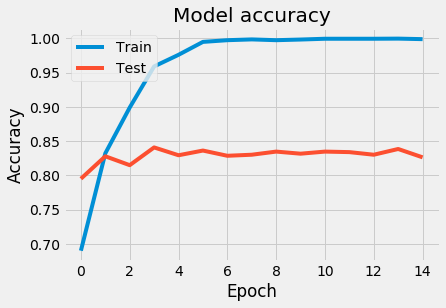

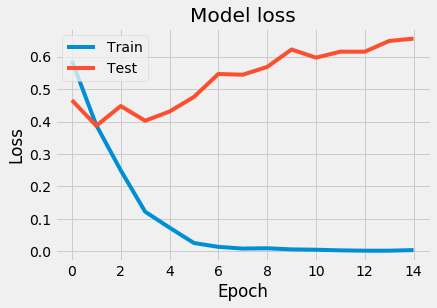

In [0]:
#Model CNN 
#Embedding GLOVE
pred_test_y=train_pred(model_cnn(embedding_matrix_1), epochs = 15)

In [0]:
from keras.models import load_model

Train on 5254 samples, validate on 1314 samples
Epoch 1/10
5254/5254 [==============================] - 5s 972us/step - loss: 0.5791 - acc: 0.7040 - val_loss: 0.4383 - val_acc: 0.8257
Epoch 2/10
5254/5254 [==============================] - 4s 726us/step - loss: 0.3250 - acc: 0.8691 - val_loss: 0.3616 - val_acc: 0.8311
Epoch 3/10
5254/5254 [==============================] - 4s 727us/step - loss: 0.1183 - acc: 0.9648 - val_loss: 0.3666 - val_acc: 0.8379
Epoch 4/10
5254/5254 [==============================] - 4s 728us/step - loss: 0.0314 - acc: 0.9941 - val_loss: 0.4621 - val_acc: 0.8257
Epoch 5/10
5254/5254 [==============================] - 4s 726us/step - loss: 0.0113 - acc: 0.9989 - val_loss: 0.4284 - val_acc: 0.8371
Epoch 6/10
5254/5254 [==============================] - 4s 731us/step - loss: 0.0059 - acc: 0.9992 - val_loss: 0.4771 - val_acc: 0.8371
Epoch 7/10
5254/5254 [==============================] - 4s 732us/step - loss: 0.0042 - acc: 0.9996 - val_loss: 0.5083 - val_acc: 0.8425


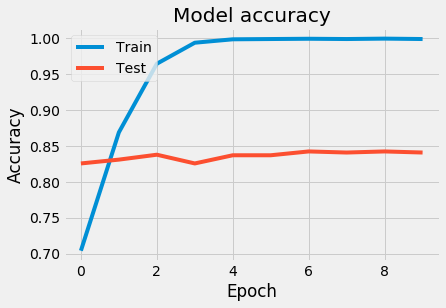

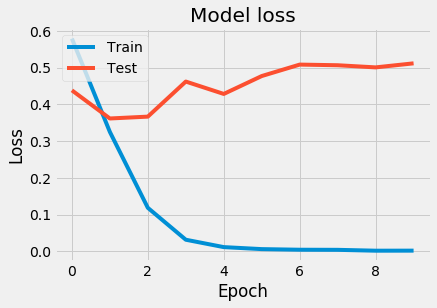

In [0]:
#Model CNN 
#Embedding FastText
train_pred(model_cnn(embedding_matrix_2), epochs = 10)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 5s 1ms/step - loss: 0.6035 - acc: 0.6823 - val_loss: 0.4464 - val_acc: 0.7976
Epoch 2/15
5254/5254 [==============================] - 4s 737us/step - loss: 0.4305 - acc: 0.8051 - val_loss: 0.3924 - val_acc: 0.8326
Epoch 3/15
5254/5254 [==============================] - 4s 737us/step - loss: 0.3167 - acc: 0.8630 - val_loss: 0.3875 - val_acc: 0.8257
Epoch 4/15
5254/5254 [==============================] - 4s 737us/step - loss: 0.2143 - acc: 0.9153 - val_loss: 0.3752 - val_acc: 0.8311
Epoch 5/15
5254/5254 [==============================] - 4s 735us/step - loss: 0.1034 - acc: 0.9673 - val_loss: 0.4116 - val_acc: 0.8303
Epoch 6/15
5254/5254 [==============================] - 4s 742us/step - loss: 0.0509 - acc: 0.9859 - val_loss: 0.4339 - val_acc: 0.8250
Epoch 7/15
5254/5254 [==============================] - 4s 736us/step - loss: 0.0340 - acc: 0.9905 - val_loss: 0.4620 - val_acc: 0.8311
Ep

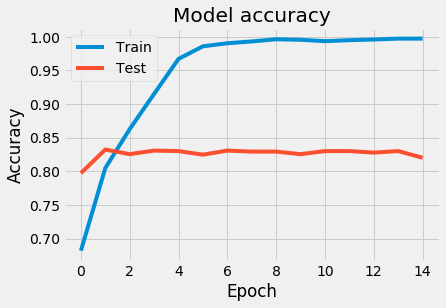

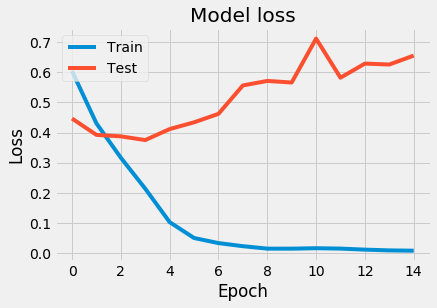

In [0]:
#Model CNN 
#Embedding Paragram
train_pred(model_cnn(embedding_matrix_3), epochs = 15)

In [0]:
#Model CNN 
#Embedding Combined
train_pred(model_cnn(embedding_matrix), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 16s 3ms/step - loss: 0.5848 - acc: 0.6892 - val_loss: 0.4932 - val_acc: 0.7588
Epoch 2/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4564 - acc: 0.7929 - val_loss: 0.4261 - val_acc: 0.7960
Epoch 3/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4178 - acc: 0.8163 - val_loss: 0.3913 - val_acc: 0.8333
Epoch 4/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3939 - acc: 0.8289 - val_loss: 0.3750 - val_acc: 0.8333
Epoch 5/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3583 - acc: 0.8445 - val_loss: 0.3884 - val_acc: 0.8234
Epoch 6/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3359 - acc: 0.8620 - val_loss: 0.3635 - val_acc: 0.8402
Epoch 7/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3161 - acc: 0.8710 - val_loss: 0.3764 - val_acc: 0.8288
Epoch 8

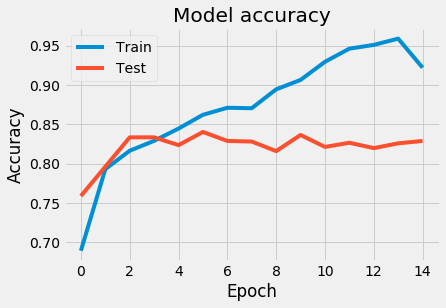

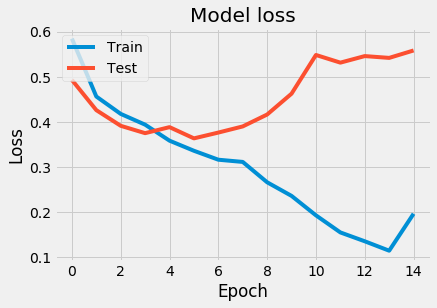

In [0]:
#Model CNN 
#Embedding GLOVE
train_pred(model_lstm_atten_2(embedding_matrix_1), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 17s 3ms/step - loss: 0.6559 - acc: 0.6144 - val_loss: 0.6425 - val_acc: 0.6187
Epoch 2/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.6391 - acc: 0.6412 - val_loss: 0.7450 - val_acc: 0.6111
Epoch 3/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.5874 - acc: 0.7052 - val_loss: 0.5054 - val_acc: 0.7534
Epoch 4/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4888 - acc: 0.7731 - val_loss: 0.4378 - val_acc: 0.7998
Epoch 5/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4487 - acc: 0.8032 - val_loss: 0.4479 - val_acc: 0.7976
Epoch 6/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4228 - acc: 0.8171 - val_loss: 0.4454 - val_acc: 0.8006
Epoch 7/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4139 - acc: 0.8249 - val_loss: 0.4210 - val_acc: 0.8067
Epoch 8

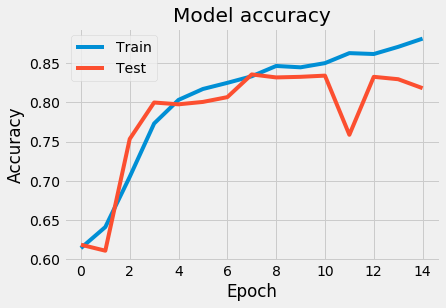

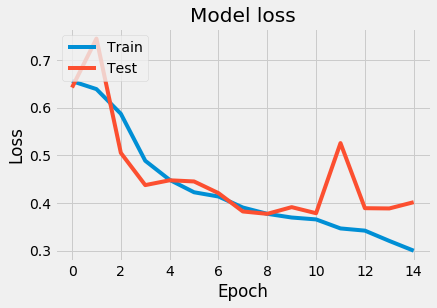

In [0]:
#Model CNN 
#Embedding FastText
train_pred(model_lstm_atten_2(embedding_matrix_2), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 18s 3ms/step - loss: 0.5747 - acc: 0.7010 - val_loss: 0.4484 - val_acc: 0.7953
Epoch 2/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4386 - acc: 0.8083 - val_loss: 0.3993 - val_acc: 0.8272
Epoch 3/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3898 - acc: 0.8325 - val_loss: 0.4796 - val_acc: 0.7983
Epoch 4/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3631 - acc: 0.8477 - val_loss: 0.3783 - val_acc: 0.8288
Epoch 5/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3080 - acc: 0.8710 - val_loss: 0.3883 - val_acc: 0.8333
Epoch 6/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.2697 - acc: 0.8928 - val_loss: 0.3886 - val_acc: 0.8349
Epoch 7/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.2176 - acc: 0.9218 - val_loss: 0.7914 - val_acc: 0.7093
Epoch 8

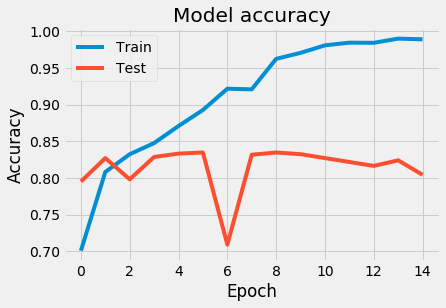

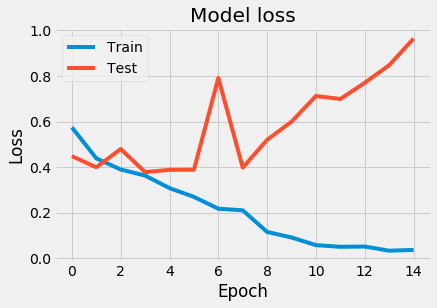

In [0]:
#Model CNN 
#Embedding Paragram
train_pred(model_lstm_atten_2(embedding_matrix_3), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 18s 3ms/step - loss: 0.5788 - acc: 0.6928 - val_loss: 0.5279 - val_acc: 0.7435
Epoch 2/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4549 - acc: 0.7977 - val_loss: 0.4286 - val_acc: 0.8059
Epoch 3/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.4128 - acc: 0.8196 - val_loss: 0.3804 - val_acc: 0.8303
Epoch 4/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3890 - acc: 0.8338 - val_loss: 0.3853 - val_acc: 0.8242
Epoch 5/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3594 - acc: 0.8447 - val_loss: 0.3731 - val_acc: 0.8295
Epoch 6/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3504 - acc: 0.8553 - val_loss: 0.3634 - val_acc: 0.8371
Epoch 7/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.3104 - acc: 0.8689 - val_loss: 0.3769 - val_acc: 0.8425
Epoch 8

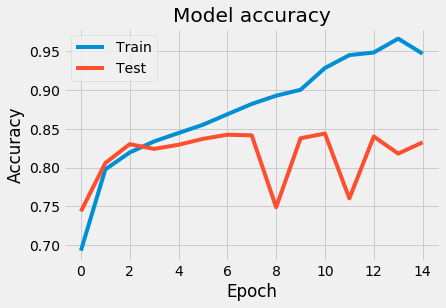

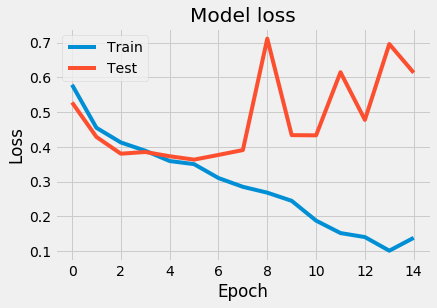

In [0]:
#Model CNN 
#Embedding Combined
train_pred(model_lstm_atten_2(embedding_matrix), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 12s 2ms/step - loss: 0.6044 - acc: 0.6580 - val_loss: 0.4410 - val_acc: 0.8059
Epoch 2/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.4218 - acc: 0.8219 - val_loss: 0.3787 - val_acc: 0.8371
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.3047 - acc: 0.8818 - val_loss: 0.3321 - val_acc: 0.8455
Epoch 4/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.1736 - acc: 0.9389 - val_loss: 0.4102 - val_acc: 0.8501
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0817 - acc: 0.9754 - val_loss: 0.5115 - val_acc: 0.8508
Epoch 6/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0568 - acc: 0.9844 - val_loss: 0.5592 - val_acc: 0.8447
Epoch 7/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0117 - acc: 0.9970 - val_loss: 0.6917 - val_acc: 0.8409
Epoch 8/15
52

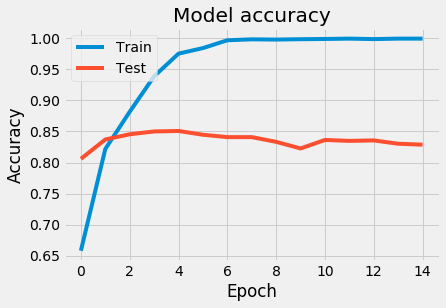

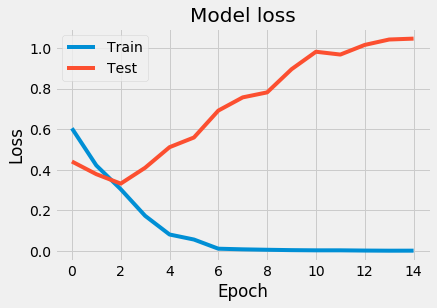

In [0]:
#Model CNN 
#Embedding GLOVE
train_pred(model_gru_ap_atten(embedding_matrix_1), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 12s 2ms/step - loss: 0.6234 - acc: 0.6498 - val_loss: 0.5244 - val_acc: 0.7618
Epoch 2/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.3657 - acc: 0.8508 - val_loss: 0.3415 - val_acc: 0.8524
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.1791 - acc: 0.9355 - val_loss: 0.4324 - val_acc: 0.8326
Epoch 4/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0668 - acc: 0.9775 - val_loss: 0.4931 - val_acc: 0.8447
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0193 - acc: 0.9943 - val_loss: 0.6406 - val_acc: 0.8295
Epoch 6/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0163 - acc: 0.9958 - val_loss: 0.6644 - val_acc: 0.8501
Epoch 7/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0076 - acc: 0.9981 - val_loss: 0.8348 - val_acc: 0.8501
Epoch 8/15
52

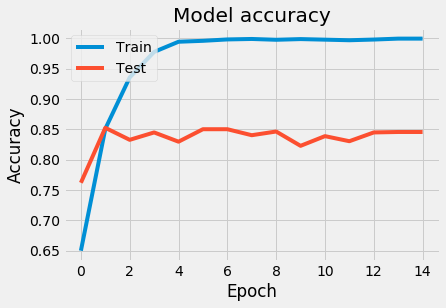

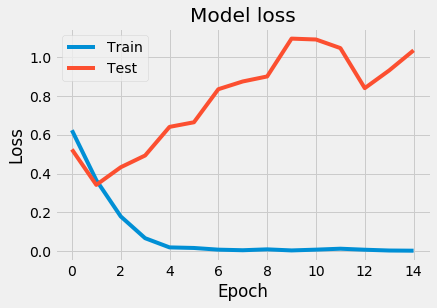

In [0]:
#Model CNN 
#Embedding FastText
train_pred(model_gru_ap_atten(embedding_matrix_2), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 12s 2ms/step - loss: 0.6391 - acc: 0.6182 - val_loss: 0.4988 - val_acc: 0.7793
Epoch 2/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.4178 - acc: 0.8230 - val_loss: 0.3594 - val_acc: 0.8447
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.2670 - acc: 0.8984 - val_loss: 0.3533 - val_acc: 0.8455
Epoch 4/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.1285 - acc: 0.9568 - val_loss: 0.4544 - val_acc: 0.8409
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0599 - acc: 0.9821 - val_loss: 0.5855 - val_acc: 0.8326
Epoch 6/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0260 - acc: 0.9928 - val_loss: 0.7240 - val_acc: 0.8387
Epoch 7/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0095 - acc: 0.9979 - val_loss: 0.8740 - val_acc: 0.8341
Epoch 8/15
52

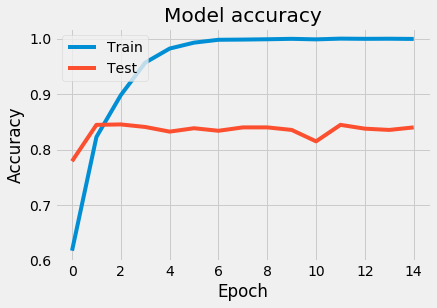

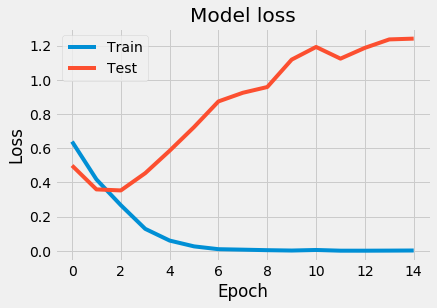

In [0]:
#Model CNN 
#Embedding Paragram
train_pred(model_gru_ap_atten(embedding_matrix_3), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 13s 2ms/step - loss: 0.6198 - acc: 0.6445 - val_loss: 0.4744 - val_acc: 0.7922
Epoch 2/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.4137 - acc: 0.8179 - val_loss: 0.3865 - val_acc: 0.8326
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.2704 - acc: 0.8890 - val_loss: 0.3678 - val_acc: 0.8486
Epoch 4/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.1411 - acc: 0.9494 - val_loss: 0.4471 - val_acc: 0.8356
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0714 - acc: 0.9783 - val_loss: 0.5321 - val_acc: 0.8440
Epoch 6/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0226 - acc: 0.9939 - val_loss: 0.6704 - val_acc: 0.8326
Epoch 7/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0120 - acc: 0.9964 - val_loss: 0.8140 - val_acc: 0.8463
Epoch 8/15
52

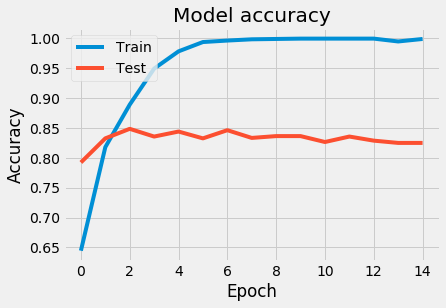

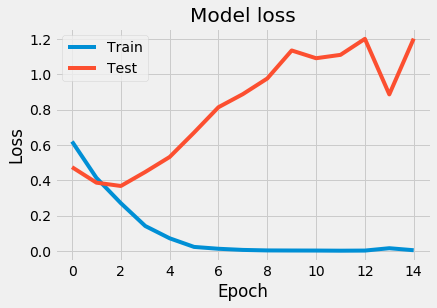

In [0]:
#Model CNN 
#Embedding Combined
train_pred(model_gru_ap_atten(embedding_matrix), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 13s 2ms/step - loss: 0.5797 - acc: 0.6917 - val_loss: 0.4555 - val_acc: 0.7930
Epoch 2/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.4081 - acc: 0.8144 - val_loss: 0.3741 - val_acc: 0.8326
Epoch 3/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.2837 - acc: 0.8822 - val_loss: 0.3561 - val_acc: 0.8379
Epoch 4/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.1657 - acc: 0.9397 - val_loss: 0.3394 - val_acc: 0.8387
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0538 - acc: 0.9888 - val_loss: 0.3911 - val_acc: 0.8470
Epoch 6/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0159 - acc: 0.9987 - val_loss: 0.4534 - val_acc: 0.8463
Epoch 7/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0076 - acc: 0.9987 - val_loss: 0.4589 - val_acc: 0.8409
Epoch 8/15
52

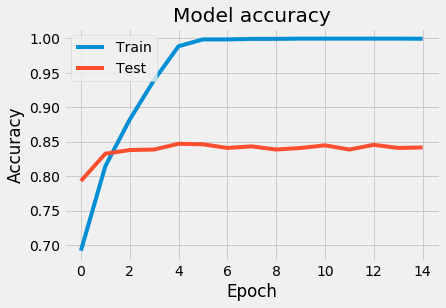

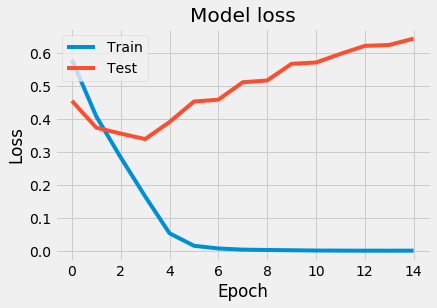

In [0]:
#Model CNN 
#Embedding GLOVE
train_pred(model_lstm_du(embedding_matrix_1), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 13s 3ms/step - loss: 0.6017 - acc: 0.6742 - val_loss: 0.5823 - val_acc: 0.6857
Epoch 2/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.3869 - acc: 0.8295 - val_loss: 0.3575 - val_acc: 0.8387
Epoch 3/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.1868 - acc: 0.9298 - val_loss: 0.3612 - val_acc: 0.8349
Epoch 4/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0489 - acc: 0.9903 - val_loss: 0.4005 - val_acc: 0.8455
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0104 - acc: 0.9985 - val_loss: 0.4954 - val_acc: 0.8425
Epoch 6/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0052 - acc: 0.9990 - val_loss: 0.5606 - val_acc: 0.8417
Epoch 7/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.5656 - val_acc: 0.8371
Epoch 8/15
52

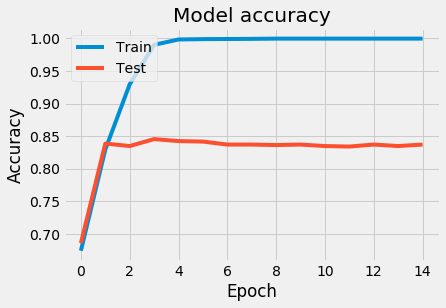

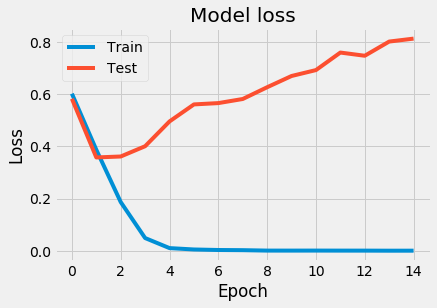

In [0]:
#Model CNN 
#Embedding FastText
train_pred(model_lstm_du(embedding_matrix_2), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.6052 - acc: 0.6713 - val_loss: 0.5348 - val_acc: 0.7314
Epoch 2/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.4256 - acc: 0.8070 - val_loss: 0.3732 - val_acc: 0.8394
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.3000 - acc: 0.8767 - val_loss: 0.3553 - val_acc: 0.8356
Epoch 4/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.1543 - acc: 0.9484 - val_loss: 0.3620 - val_acc: 0.8478
Epoch 5/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0549 - acc: 0.9829 - val_loss: 0.4475 - val_acc: 0.8295
Epoch 6/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0132 - acc: 0.9970 - val_loss: 0.5912 - val_acc: 0.8478
Epoch 7/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0053 - acc: 0.9989 - val_loss: 0.6725 - val_acc: 0.8257
Epoch 8/15
52

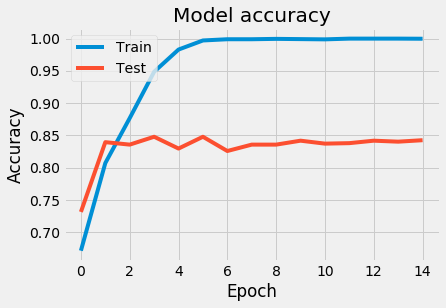

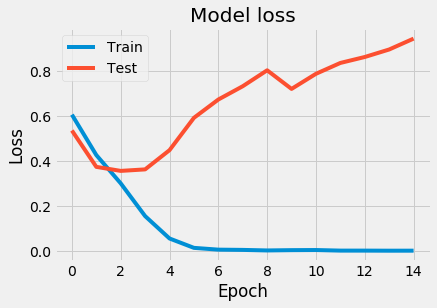

In [0]:
#Model CNN 
#Embedding Paragram
train_pred(model_lstm_du(embedding_matrix_3), epochs = 15)

Train on 5254 samples, validate on 1314 samples
Epoch 1/15
5254/5254 [==============================] - 14s 3ms/step - loss: 0.5545 - acc: 0.7181 - val_loss: 0.4575 - val_acc: 0.7953
Epoch 2/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.3793 - acc: 0.8369 - val_loss: 0.3580 - val_acc: 0.8371
Epoch 3/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.2305 - acc: 0.9128 - val_loss: 0.3463 - val_acc: 0.8440
Epoch 4/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0919 - acc: 0.9718 - val_loss: 0.3732 - val_acc: 0.8524
Epoch 5/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0209 - acc: 0.9971 - val_loss: 0.4833 - val_acc: 0.8455
Epoch 6/15
5254/5254 [==============================] - 8s 1ms/step - loss: 0.0099 - acc: 0.9981 - val_loss: 0.5835 - val_acc: 0.8440
Epoch 7/15
5254/5254 [==============================] - 7s 1ms/step - loss: 0.0069 - acc: 0.9989 - val_loss: 0.5277 - val_acc: 0.8272
Epoch 8/15
52

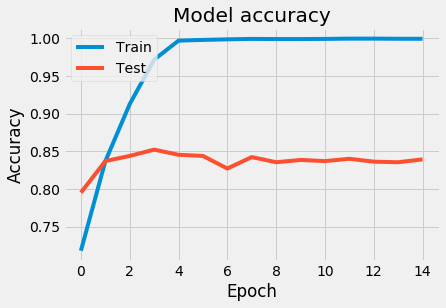

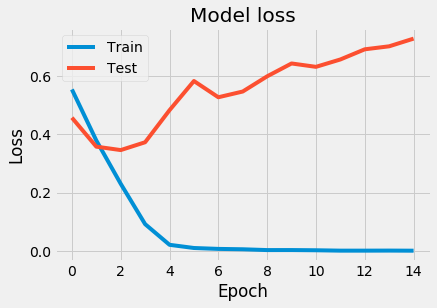

In [0]:
#Model CNN 
#Embedding Combined
train_pred(model_lstm_du(embedding_matrix), epochs = 15)

In [0]:
#Model CNN 
#Embedding GLOVE
train_pred(model_gru_atten_3(embedding_matrix_1), epochs = 150)

Train on 5254 samples, validate on 1314 samples
Epoch 1/150
5254/5254 [==============================] - 28s 5ms/step - loss: 0.5259 - acc: 0.7404 - val_loss: 0.4122 - val_acc: 0.8250
Epoch 2/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.4159 - acc: 0.8217 - val_loss: 0.3998 - val_acc: 0.8265
Epoch 3/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.4044 - acc: 0.8308 - val_loss: 0.3664 - val_acc: 0.8409
Epoch 4/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.3776 - acc: 0.8441 - val_loss: 0.3622 - val_acc: 0.8394
Epoch 5/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.3516 - acc: 0.8544 - val_loss: 0.3906 - val_acc: 0.8288
Epoch 6/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.3454 - acc: 0.8576 - val_loss: 0.3515 - val_acc: 0.8364
Epoch 7/150
5254/5254 [==============================] - 20s 4ms/step - loss: 0.3150 - acc: 0.8687 - val_loss: 0.3743 - val_acc: 0.8265


In [0]:
#Model CNN 
#Embedding FastText
train_pred(model_gru_atten_3(embedding_matrix_2), epochs = 15)

In [0]:
#Model CNN 
#Embedding Paragram
train_pred(model_gru_atten_3(embedding_matrix_3), epochs = 15)

In [0]:
#Model CNN 
#Embedding Combined
train_pred(model_gru_atten_3(embedding_matrix), epochs = 15)

In [0]:
def train_pred_new(model, epochs):
    history=model.fit([train_X,train_df['ratio']], train_y, batch_size=8,epochs=epochs,verbose=1,validation_split=.2)
    pred_test_y = model.predict([test_X,test_df['ratio']], batch_size=1024, verbose=0)
    #pred_test_y = model.predict([test_X], batch_size=1024, verbose=0)
    #Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return pred_test_y #pred_val_y, pred_test_y

Train on 1120 samples, validate on 281 samples
Epoch 1/10
1120/1120 [==============================] - 26s 23ms/step - loss: 0.5529 - acc: 0.7295 - val_loss: 0.3551 - val_acc: 0.8007
Epoch 2/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.3634 - acc: 0.8429 - val_loss: 0.3334 - val_acc: 0.8434
Epoch 3/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.3332 - acc: 0.8723 - val_loss: 0.3636 - val_acc: 0.8327
Epoch 4/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.2971 - acc: 0.8741 - val_loss: 0.3137 - val_acc: 0.8577
Epoch 5/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.2474 - acc: 0.8973 - val_loss: 0.2816 - val_acc: 0.8932
Epoch 6/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.2255 - acc: 0.8955 - val_loss: 0.2662 - val_acc: 0.9004
Epoch 7/10
1120/1120 [==============================] - 16s 14ms/step - loss: 0.1928 - acc: 0.9286 - val_loss: 0.2868 - val_acc: 0.8897
E

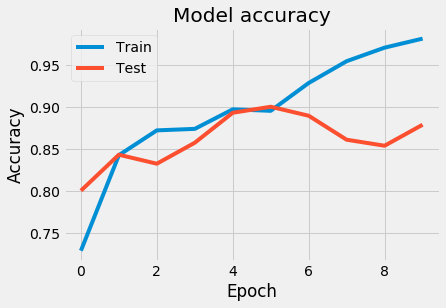

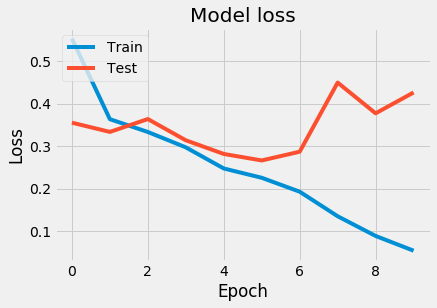

In [0]:
pred_test_y = train_pred+_new(model_gru_atten_3(embedding_matrix), epochs = 15)

In [0]:
pred_val_y = model.predict([test_X], batch_size=1024, verbose=0)

In [0]:
pred_test_y = (pred_test_y > 0.34).astype(int)

In [0]:
from sklearn.metrics import accuracy_score
print(accuracy_score(test_y, pred_test_y))


0.8717948717948718
